# **Video Processing Week 1: Fondasi & Teknik CV Klasik**

Minggu ini kita akan mempelajari **pengolahan video frame-by-frame** dengan teknik-teknik klasik (non-AI) menggunakan OpenCV. Fokus utama adalah manipulasi video real-time maupun file, serta efek dasar yang sering digunakan dalam produksi video.

**Tujuan Pembelajaran:**

Di akhir sesi ini kita akan bisa:
- Membaca, menulis, dan menangkap video (file & webcam).
- Mengkonversi colorspace dan menerapkan filter dasar (blur, edge).
- Membuat efek *chroma key* (green screen) dengan mask warna.
- Melakukan *object tracking* menggunakan algoritma OpenCV (CSRT/KCF).
- (Opsional) Men-stabilkan video dengan fitur bawaan OpenCV.

> *This module is inspired by the development of last semester’s materials.* 

## **Pengantar Video Processing**

### **Apa itu Video?**

**Video** adalah rangkaian gambar (frame) yang ditampilkan secara berurutan dengan kecepatan tertentu (frame rate).  
- Satuan video adalah **frame** (gambar individu)  
- **Frame rate** diukur dalam fps (frames per second) - umumnya 24, 30, atau 60 fps  
- Video bisa berasal dari file atau device seperti webcam  

Dalam pengolahan video, kita akan:
1. Membaca dan menulis file video
2. Memproses setiap frame secara individual
3. Menerapkan efek dan teknik khusus video
4. Menangkap video dari webcam untuk processing real-time

*Sebelum lanjut, kita coba import library yang akan kita butuhkan dulu*

**⚠️ PENTING: Install library `opencv-contrib-python`, bukan `opencv-python`. Fitur object detection hanya tersedia di library `opencv-contrib-python`**

In [1]:
%pip install opencv-contrib-python==4.11.0.86 numpy matplotlib ipykernel

Note: you may need to restart the kernel to use updated packages.


c:\Users\muham\OneDrive\Desktop\sistem-teknologi-multimedia-122140193\multimedia-uv\Scripts\python.exe: No module named pip


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Fundamental Video I/O (OpenCV)

Video hanyalah rangkaian gambar diam (disebut frames) yang ditampilkan secara berurutan dengan sangat cepat.

Ketika gambar-gambar ini ditampilkan dengan kecepatan tertentu, misalnya 24, 30, atau 60 gambar setiap detiknya, mata kita akan menangkapnya sebagai sebuah gerakan ilusi yang mulus. Kecepatan pemutaran ini disebut Frames Per Second (FPS).

Kita akan belajar cara menggunakan OpenCV untuk melakukan pengolahan video dari file dan dari kamera secara real-time.

### Membaca file video

Kita akan mencoba membuka file video menggunakan OpenCV dan menampilkan:
- frame pertama dan frame ke-n
- Video di dalam window terpisah

Dimensi Frame: (720, 1280, 3)


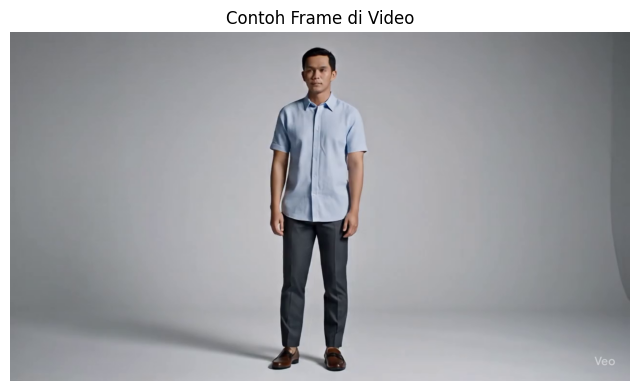

In [3]:
# Membaca frame dari video
PATH_VIDEO = os.path.join(os.getcwd(), 'data', 'man_walking.mp4')

cap = cv2.VideoCapture(PATH_VIDEO)
if cap.isOpened():
    # Membaca frame ke-n (misal frame ke-10) | Uncooment kode dibawah
    # frame_at = 10
    # cap.set(cv2.CAP_PROP_POS_FRAMES, frame_at - 1)
    
    ret, frame = cap.read()
    if ret:
        print(f"Dimensi Frame: {frame.shape}")
        
        # Seperti yang sudah dipelajari, OpenCV menggunakan format warna BGR secara default
        # Kita perlu mengkonversi ke RGB untuk menampilkan dengan matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(8, 5))
        plt.imshow(frame_rgb)
        plt.title("Contoh Frame di Video")
        plt.axis('off')
        plt.show()
    else:
        print(f"Error: Gagal membaca frame dari {PATH_VIDEO}. Video mungkin kosong.")
else:
    print(f"Error: Tidak bisa membuka file video di '{PATH_VIDEO}'")
    print("Pastikan nama file dan path sudah benar, atau file tidak korup.")
        
cap.release()

In [4]:
# Menampilkan video di window terpisah
# Periksa window baru di sistem operasi Anda
PATH_VIDEO = os.path.join(os.getcwd(), 'data', 'man_walking.mp4')
cap = cv2.VideoCapture(PATH_VIDEO)

if cap.isOpened():
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Video selesai")
            break
        
        cv2.imshow('Video Playback', frame)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
else:
    print(f"Error: Tidak bisa membuka file video di '{PATH_VIDEO}'")
    print("Pastikan nama file dan path sudah benar, atau file tidak korup.")

cap.release()
cv2.destroyAllWindows()

Video selesai


### Menangkap Gambar dari Webcam

Untuk menangkap video dari webcam, kita bisa menggunakan `cv2.VideoCapture(0)`, di mana `0` adalah indeks default untuk webcam pertama. Jika Anda memiliki beberapa kamera, Anda bisa mencoba `1`, `2`, dll.

In [5]:
cap = cv2.VideoCapture(0)

if cap.isOpened():
    print("Webcam berhasil diakses. Tekan 'q' untuk keluar.")
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Gagal membaca frame dari webcam")
            break
        
        cv2.imshow('Webcam Live', frame)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
else:
    print("Error: Tidak bisa mengakses webcam")
    print("Pastikan webcam terhubung dan tidak digunakan aplikasi lain")

cap.release()
cv2.destroyAllWindows()

Webcam berhasil diakses. Tekan 'q' untuk keluar.


### Menyimpan/menulis ke file video baru

Untuk menyimpan video yang telah diproses, kita dapat menggunakan `cv2.VideoWriter`. Kita perlu menentukan nama file output, codec video, frame rate, dan ukuran frame.

Kita akan mencoba mengubah video menjadi grayscale dan menyimpannya ke file baru.

In [6]:
PATH_VIDEO = os.path.join(os.getcwd(), 'data', 'man_walking.mp4')
OUTPUT_VIDEO = os.path.join(os.getcwd(), 'data', 'output_grayscale.mp4')

# Baca video input
cap = cv2.VideoCapture(PATH_VIDEO)

if cap.isOpened():
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec untuk MP4
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))
    
    print(f"Menyimpan video grayscale ke: {OUTPUT_VIDEO}")
    print(f"Resolusi: {frame_width}x{frame_height}, FPS: {fps}")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Proses selesai!")
            break
        
        # Konversi frame ke grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Konversi kembali ke BGR agar bisa disimpan sebagai video berwarna
        gray_bgr = cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR)
        out.write(gray_bgr)
        cv2.imshow('Processing Video - Grayscale', gray_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release semua resource
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    print(f"Video grayscale berhasil disimpan di: {OUTPUT_VIDEO}")
else:
    print(f"Error: Tidak bisa membuka file video di '{PATH_VIDEO}'")

Menyimpan video grayscale ke: c:\Users\muham\OneDrive\Desktop\sistem-teknologi-multimedia-122140193\worksheet5\data\output_grayscale.mp4
Resolusi: 1280x720, FPS: 24
Video grayscale berhasil disimpan di: c:\Users\muham\OneDrive\Desktop\sistem-teknologi-multimedia-122140193\worksheet5\data\output_grayscale.mp4


## Manipulasi Frame Dasar

Setelah berhasil membaca dan menulis video, kita akan mempelajari teknik-teknik dasar untuk memanipulasi setiap frame dalam video. Manipulasi frame adalah fondasi dari semua efek video processing:

### **Konversi Colorspace**
Mengubah representasi warna frame (BGR → Grayscale, BGR → HSV, dll) untuk kebutuhan analisis atau efek tertentu.

**1. BGR to Grayscale:**
- Mengubah gambar berwarna menjadi hitam-putih
- Menghilangkan informasi warna, hanya menyimpan intensitas cahaya
- Mengurangi 3 channel (Blue, Green, Red) menjadi 1 channel saja
- Berguna untuk analisis bentuk, deteksi tepi, dan mengurangi kompleksitas komputasi

**2. BGR to HSV:**
- **H (Hue)**: Jenis warna (0-179° dalam OpenCV)
- **S (Saturation)**: Tingkat kejenuhan/kemurnian warna (0-255)
- **V (Value)**: Kecerahan/intensitas warna (0-255)
- Lebih intuitif untuk pemrosesan berdasarkan warna tertentu
- Sangat berguna untuk chroma keying (green screen) dan color-based object detection

In [7]:
# Konversi frame webcam ke Grayscale
cap = cv2.VideoCapture(0)

if cap.isOpened():
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Gagal membaca frame dari webcam")
            break
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('Webcam Live - Grayscale', gray_frame)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
else:
    print("Error: Tidak bisa mengakses webcam")
    print("Pastikan webcam terhubung dan tidak digunakan aplikasi lain")

cap.release()
cv2.destroyAllWindows()

In [8]:
# Konversi frame webcam ke HSV
cap = cv2.VideoCapture(0)

if cap.isOpened():
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Gagal membaca frame dari webcam")
            break
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        cv2.imshow('Webcam Live - HSV', hsv_frame)

        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
else:
    print("Error: Tidak bisa mengakses webcam")
    print("Pastikan webcam terhubung dan tidak digunakan aplikasi lain")

cap.release()
cv2.destroyAllWindows()

### **Filter Dasar**

Setelah konversi colorspace, kita akan mempelajari filter dasar yang sering digunakan dalam video processing:

**1. Blur Filter:**
- Menghaluskan gambar dengan mengurangi noise dan detail halus
- Membuat efek buram dengan merata-ratakan nilai pixel di sekitarnya
- Berguna untuk preprocessing sebelum deteksi objek atau mengurangi gangguan
- Jenis blur: Gaussian Blur, Motion Blur, dan Median Blur

**2. Canny Edge Detection:**
- Mendeteksi tepi/garis batas objek dalam gambar
- Mengubah gambar menjadi representasi garis putih pada latar belakang hitam
- Sangat berguna untuk analisis bentuk, kontur objek, dan segmentasi
- Menggunakan algoritma gradien untuk menemukan perubahan intensitas yang tajam

In [9]:
# Average Blur (paling sederhana) pada webcam
cap = cv2.VideoCapture(0)

if cap.isOpened():
    print("Webcam berhasil diakses. Tekan 'q' untuk keluar.")
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Gagal membaca frame dari webcam")
            break
        
        # Hanya butuh 1 parameter: kernel size
        blurred = cv2.blur(frame, (15, 15))
        
        # Tampilkan original dan blurred
        cv2.imshow('Average Blur', blurred)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
else:
    print("Error: Tidak bisa mengakses webcam")

cap.release()
cv2.destroyAllWindows()

Webcam berhasil diakses. Tekan 'q' untuk keluar.


In [10]:
# Canny Edge Detection pada webcam
cap = cv2.VideoCapture(0)

if cap.isOpened():
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Gagal membaca frame dari webcam")
            break
        
        # Konversi ke grayscale terlebih dahulu (Canny memerlukan grayscale)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Terapkan Canny Edge Detection
        # Parameter: (image, threshold1, threshold2)
        # threshold1: batas bawah untuk edge detection
        # threshold2: batas atas untuk edge detection
        edges = cv2.Canny(gray, 100, 150)
        
        # Tampilkan original dan edges
        cv2.imshow('Canny Edge Detection', edges)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
else:
    print("Error: Tidak bisa mengakses webcam")
    print("Pastikan webcam terhubung dan tidak digunakan aplikasi lain")

cap.release()
cv2.destroyAllWindows()

## Chroma Keying (Efek "Green Screen")

Chroma keying adalah teknik mengganti background berdasarkan warna tertentu (biasanya hijau atau biru) dengan gambar/video lain. Teknik ini sangat populer dalam industri film dan broadcasting.

**Konsep Dasar:**
- **Background khusus**: Objek direkam di depan layar berwarna solid (green screen/blue screen)
- **Color separation**: Algoritma memisahkan warna background dari foreground
- **Compositing**: Background diganti dengan gambar/video yang diinginkan

**Catatan**:
- Hindari objek yang berwarna hijau agar tidak ikut ter-mask
- Kualitas hasil tergantung pada kualitas green screen dan pencahayaan

**Langkah-langkah Chroma Keying:**

### **1. Membuat Mask Berdasarkan Rentang Warna (Hijau)**
- Konversi frame ke HSV colorspace untuk deteksi warna yang lebih akurat
- Tentukan rentang nilai HSV untuk warna hijau (Hue: 40-80, Saturation: tinggi, Value: tinggi)
- Gunakan `cv2.inRange()` untuk membuat binary mask (putih = hijau, hitam = bukan hijau)
- Terapkan **morphological operations** untuk membersihkan mask:
    - **Erosi**: menghilangkan titik-titik noise kecil
    - **Dilasi**: menutup lubang-lubang kecil di dalam mask
    - Hasil: mask yang lebih bersih dan solid

In [11]:
# Membuat mask berdasarkan rentang warna hijau
PATH_VIDEO = os.path.join(os.getcwd(), 'data', 'green_screen_sample.mp4')

cap = cv2.VideoCapture(PATH_VIDEO)
if cap.isOpened():
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Video selesai atau tidak bisa membaca frame")
            break
        
        # 1. Konversi frame ke HSV colorspace
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # 2. Tentukan rentang warna hijau dalam HSV
        # Hue: 40-80 (hijau), Saturation: 40-255 (cukup jenuh), Value: 40-255 (cukup terang)
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 3. Buat binary mask menggunakan cv2.inRange()
        # Pixel hijau akan menjadi putih (255), sisanya hitam (0)
        mask = cv2.inRange(hsv_frame, lower_green, upper_green)
        
        # 4. Terapkan morphological operations untuk membersihkan noise
        # Erosi: menghilangkan noise kecil
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        # Dilasi: menutup lubang kecil di mask
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # Tampilkan hasil
        cv2.imshow('Original Frame', frame)
        cv2.imshow('HSV Frame', hsv_frame)
        cv2.imshow('Green Mask', mask)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
else:
    print(f"Error: Tidak bisa membuka file video di '{PATH_VIDEO}'")
    print("Pastikan file 'green_screen_sample.mp4' ada di folder 'data'")

cap.release()
cv2.destroyAllWindows()

### **2. Mengganti Area Mask dengan Gambar atau Video Lain**
- Load 2 video: Green screen dan background replacement
- Deteksi hijau: Konversi ke HSV, buat mask untuk area hijau dengan cv2.inRange()
- Bersihkan mask: Morphological operations (OPEN & CLOSE) untuk hapus noise
- Pisahkan objek & background: bitwise_and() dengan mask asli dan mask terbalik
- Gabungkan hasil: cv2.add() foreground + background = green screen diganti

In [12]:
# Chroma Keying: Mengganti green screen dengan video lain
PATH_VIDEO_GREEN = os.path.join(os.getcwd(), 'data', 'green_screen_sample.mp4')
PATH_VIDEO_BG = os.path.join(os.getcwd(), 'data', 'man_walking.mp4')

cap_green = cv2.VideoCapture(PATH_VIDEO_GREEN)
cap_bg = cv2.VideoCapture(PATH_VIDEO_BG)

if cap_green.isOpened() and cap_bg.isOpened():
    print("Kedua video berhasil dibuka. Tekan 'q' untuk keluar.")
    
    # Dapatkan dimensi frame green screen
    frame_width = int(cap_green.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap_green.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    while True:
        ret_green, frame_green = cap_green.read()
        ret_bg, frame_bg = cap_bg.read()
        
        if not ret_green or not ret_bg:
            print("Salah satu video source atau green screen selesai")
            break
        
        # 1. Konversi frame ke HSV colorspace
        hsv_frame = cv2.cvtColor(frame_green, cv2.COLOR_BGR2HSV)
        
        # 2. Tentukan rentang warna hijau dalam HSV
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 3. Buat binary mask
        mask = cv2.inRange(hsv_frame, lower_green, upper_green)
        
        # 4. Terapkan morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        # 5. Invert mask (background = putih, foreground = hitam)
        mask_inv = cv2.bitwise_not(mask)
        
        # 6. Ekstrak foreground (objek) dari frame original
        foreground = cv2.bitwise_and(frame_green, frame_green, mask=mask_inv)
        
        # 7. Ekstrak background dari video pengganti
        background = cv2.bitwise_and(frame_bg, frame_bg, mask=mask)
        
        # 8. Gabungkan foreground dan background
        result = cv2.add(foreground, background)
        
        cv2.imshow('Result - Chroma Key', result)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
else:
    if not cap_green.isOpened():
        print(f"Error: Tidak bisa membuka {PATH_VIDEO_GREEN}")
    if not cap_bg.isOpened():
        print(f"Error: Tidak bisa membuka {PATH_VIDEO_BG}")

cap_green.release()
cap_bg.release()
cv2.destroyAllWindows()

Kedua video berhasil dibuka. Tekan 'q' untuk keluar.


## Object Tracking (OpenCV Trackers)

Object tracking adalah teknik untuk mengikuti pergerakan objek tertentu di dalam video secara otomatis. Setelah kita memilih objek di frame pertama, algoritma tracker akan terus mengikuti objek tersebut di frame-frame berikutnya.

**Konsep Dasar:**
- **Inisialisasi**: Pilih objek yang ingin di-track dengan menggambar bounding box (kotak pembatas)
- **Tracking**: Algoritma mencari lokasi objek di frame berikutnya berdasarkan fitur visual
- **Update**: Posisi bounding box diperbarui mengikuti pergerakan objek

### Pengenalan Algoritma Tracker
**Jenis-jenis Tracker OpenCV:**

#### **1. CSRT (Channel and Spatial Reliability Tracker)**
- **Akurasi tinggi**: Sangat baik untuk objek yang bergerak lambat hingga sedang
- **Robust**: Tahan terhadap perubahan bentuk, rotasi, dan sebagian occlusion
- **Kecepatan**: Relatif lambat dibanding tracker lain
- **Use case**: Tracking wajah, kendaraan, objek dengan detail tinggi

#### **2. KCF (Kernelized Correlation Filters)**
- **Kecepatan tinggi**: Sangat cepat dalam komputasi
- **Akurasi sedang**: Baik untuk objek bergerak cepat tapi bentuk relatif stabil
- **Keterbatasan**: Kurang baik menangani perubahan skala dan rotasi drastis
- **Use case**: Tracking objek bergerak cepat, aplikasi real-time

#### **3. Tracker Lainnya:**
- **BOOSTING**: Tracker pertama, akurasi rendah tapi cepat
- **MIL**: Lebih robust dari BOOSTING, menangani noise dengan baik
- **TLD**: Baik untuk long-term tracking, bisa "menemukan kembali" objek yang hilang
- **MEDIANFLOW**: Sangat cepat, cocok untuk objek bergerak halus dan predictable

**Cara Kerja Umum:**
1. **Pilih ROI (Region of Interest)**: User menggambar kotak di sekitar objek
2. **Ekstraksi fitur**: Tracker mempelajari karakteristik visual objek (warna, tekstur, bentuk)
3. **Prediksi**: Berdasarkan frame sebelumnya, prediksi lokasi objek di frame berikutnya
4. **Koreksi**: Cari area yang paling mirip dengan template objek
5. **Update**: Perbarui posisi bounding box dan template objek

### Praktik: Memilih objek (via ROI) dan membiarkan tracker mengikutinya

In [13]:
# Object Tracking menggunakan CSRT Tracker
PATH_VIDEO = os.path.join(os.getcwd(), 'data', 'man_walking.mp4')

cap = cv2.VideoCapture(PATH_VIDEO)
tracker = cv2.TrackerCSRT_create()

if cap.isOpened():
    # Baca frame pertama
    ret, frame = cap.read()
    
    if ret:
        # Pilih ROI (Region of Interest) - objek yang ingin di-track
        print("Pilih objek yang ingin di-track, lalu tekan ENTER atau SPACE")
        print("Tekan 'c' untuk cancel")
        bbox = cv2.selectROI("Select Object", frame, fromCenter=False, showCrosshair=True)
        cv2.destroyWindow("Select Object")
        
        # Inisialisasi CSRT Tracker setelah pemilihan ROI
        tracker.init(frame, bbox)
    else:
        print("Tidak dapat membaca frame pertama!")
        
    # Loop per frame video dengan tracking
    while True:
        ret, frame = cap.read()
        
        if not ret:
            print("Video selesai")
            break
        
        # Update tracker - dapatkan posisi objek baru
        success, bbox = tracker.update(frame)
        
        if success:
            # Tracking berhasil - gambar bounding box
            x, y, w, h = [int(v) for v in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Tracking", (x, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        else:
            # Tracking gagal
            cv2.putText(frame, "Lost", (50, 80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        cv2.imshow('CSRT Object Tracking', frame)
        
        # Tekan 'q' untuk keluar
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
else:
    print(f"Error: Tidak bisa membuka video di '{PATH_VIDEO}'")

cap.release()
cv2.destroyAllWindows()

Pilih objek yang ingin di-track, lalu tekan ENTER atau SPACE
Tekan 'c' untuk cancel


### 🔎 Eksplorasi

- Cobalah melakukan Object Detection melalui Webcam Anda secara real-time
- Cobalah menggunakan algoritma tracker lainnya dan bandingkan hasilnya.

Hint: ubah bagian kode `tracker = cv2.TrackerCSRT_create()`

## Video Stabilization (Opsional / Pengayaan)

Video stabilization adalah teknik untuk mengurangi  getaran dalam video, menghasilkan footage yang lebih halus dan stabil untuk pengalaman menonoton yang lebih baik.

### Pengenalan singkat konsep stabilisasi video (feature matching & warping).

**Prinsip Kerja Video Stabilization:**

#### **1. Feature Detection & Matching**
- **Deteksi keypoints**: Menggunakan `cv2.goodFeaturesToTrack()` untuk menemukan titik-titik karakteristik yang mudah dikenali
- **Feature matching**: Mencocokkan keypoints yang sama antar frame berurutan
- **Tracking motion**: Menggunakan `cv2.calcOpticalFlowPyrLK()` untuk melacak pergerakan fitur-fitur tersebut

#### **2. Motion Estimation**
- **Transformasi geometris**: Menghitung bagaimana frame bergerak relatif terhadap frame sebelumnya
- **Parameter motion**: Translation (x,y), rotation, dan scaling menggunakan `cv2.estimateAffinePartial2D()`
- **Motion vector**: Mendapatkan vektor perpindahan untuk setiap frame

#### **3. Trajectory Smoothing**
- **Raw trajectory**: Kumpulan semua motion vector (biasanya bergelombang/noisy)
- **Smooth trajectory**: Aplikasi moving average atau filter lain untuk menghaluskan pergerakan
- **Stabilization**: Selisih antara raw dan smooth trajectory menjadi koreksi yang dibutuhkan

#### **4. Frame Correction & Warping**
- **Geometric transformation**: Menerapkan koreksi menggunakan `cv2.warpAffine()` atau `cv2.warpPerspective()`
- **Frame warping**: Merotasi, mentranslasi, atau menskalakan frame untuk mengkompensasi goyangan
- **Border handling**: Mengatasi area kosong akibat transformasi (crop, interpolation, atau border replication)

**Kelebihan & Keterbatasan:**
- ✅ **Efektif**: Mengurangi goyangan secara signifikan untuk kebanyakan kasus
- ✅ **Non-destructive**: Tidak merusak kualitas visual secara drastis
- ❌ **Cropping**: Memerlukan sedikit crop di tepi frame untuk ruang koreksi
- ❌ **Rolling shutter**: Kurang efektif untuk distorsi rolling shutter kamera smartphone

In [ ]:
# Video Stabilization - Teknik Optical Flow
PATH_VIDEO = os.path.join(os.getcwd(), 'data', 'unstabilized_video.mp4')
OUTPUT_VIDEO = os.path.join(os.getcwd(), 'data', 'stabilized_video.mp4')

cap = cv2.VideoCapture(PATH_VIDEO)

if not cap.isOpened():
    print(f"Error: Tidak bisa membuka video di '{PATH_VIDEO}'")
else:
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))
    
    # Baca frame pertama
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    # Storage untuk transformasi
    transforms = []
    
    print("Menghitung transformasi antar frame...")
    # PASS 1: Hitung transformasi untuk setiap frame
    for i in range(n_frames - 1):
        ret, curr_frame = cap.read()
        if not ret:
            break
        
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # 1. Deteksi fitur corner di frame sebelumnya
        prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, 
                                           qualityLevel=0.01, minDistance=30)
        
        if prev_pts is not None:
            # 2. Track fitur ke frame sekarang menggunakan optical flow
            curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
            
            # Filter hanya point yang berhasil di-track
            idx = np.where(status == 1)[0]
            prev_pts = prev_pts[idx]
            curr_pts = curr_pts[idx]
            
            # 3. Estimasi transformasi affine (translation + rotation)
            m, inliers = cv2.estimateAffinePartial2D(prev_pts, curr_pts)
            
            if m is not None:
                # Ekstrak dx, dy (translasi) dan da (rotasi)
                dx = m[0, 2]
                dy = m[1, 2]
                da = np.arctan2(m[1, 0], m[0, 0])
            else:
                dx = dy = da = 0
            
            transforms.append([dx, dy, da])
        else:
            transforms.append([0, 0, 0])
        
        prev_gray = curr_gray
        
        if i % 30 == 0:
            print(f"Progress: {i}/{n_frames-1}")
    
    # Konversi ke numpy array
    transforms = np.array(transforms)
    
    # 4. Hitung trajectory (cumulative sum)
    trajectory = np.cumsum(transforms, axis=0)
    
    # 5. Smooth trajectory dengan moving average
    smoothed_trajectory = np.copy(trajectory)
    SMOOTHING_RADIUS = 30  # Window size untuk smoothing
    
    for i in range(3):  # dx, dy, da
        for j in range(len(trajectory)):
            start = max(0, j - SMOOTHING_RADIUS)
            end = min(len(trajectory), j + SMOOTHING_RADIUS + 1)
            smoothed_trajectory[j, i] = np.mean(trajectory[start:end, i])
    
    # 6. Hitung perbedaan antara trajectory smooth dan original
    diff = smoothed_trajectory - trajectory
    transforms_smooth = transforms + diff
    
    # Reset video ke awal
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    print("Menerapkan stabilisasi...")
    
    # PASS 2: Terapkan transformasi yang sudah di-smooth
    for i, transform in enumerate(transforms_smooth):
        ret, frame = cap.read()
        if not ret:
            break
        
        dx, dy, da = transform
        
        # 7. Buat matrix transformasi affine
        m = np.array([[np.cos(da), -np.sin(da), dx],
                      [np.sin(da), np.cos(da), dy]])
        
        # 8. Apply transformation (warp affine)
        frame_stabilized = cv2.warpAffine(frame, m, (frame_width, frame_height))
        
        # Crop untuk menghilangkan border hitam
        frame_stabilized = frame_stabilized[50:frame_height-50, 50:frame_width-50]
        frame_stabilized = cv2.resize(frame_stabilized, (frame_width, frame_height))
        
        out.write(frame_stabilized)
        
        # Tampilkan comparison
        cv2.imshow('Original', frame)
        cv2.imshow('Stabilized', frame_stabilized)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        if i % 30 == 0:
            print(f"Stabilisasi: {i}/{len(transforms_smooth)}")
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    print(f"Video stabilisasi selesai! Tersimpan di: {OUTPUT_VIDEO}")

Menghitung transformasi antar frame...
Progress: 0/1000
Progress: 30/1000
Progress: 60/1000
Progress: 90/1000
Progress: 120/1000
Progress: 150/1000
Progress: 180/1000
Progress: 210/1000
Progress: 240/1000
Progress: 270/1000
Progress: 300/1000
Progress: 330/1000
Progress: 360/1000
Progress: 390/1000
Progress: 420/1000
Progress: 450/1000
Progress: 480/1000
Progress: 510/1000
Progress: 540/1000
Progress: 570/1000
Progress: 600/1000
Progress: 630/1000
Progress: 660/1000
Progress: 690/1000
Progress: 720/1000
Progress: 750/1000
Progress: 780/1000
Progress: 810/1000
Progress: 840/1000
Progress: 870/1000
Progress: 900/1000
Progress: 930/1000
Progress: 960/1000
Progress: 990/1000
Menerapkan stabilisasi...
Stabilisasi: 0/1000
Stabilisasi: 30/1000
Stabilisasi: 60/1000
Stabilisasi: 90/1000
Stabilisasi: 120/1000
Stabilisasi: 150/1000
Video stabilisasi selesai! Tersimpan di: c:\Users\muham\OneDrive\Desktop\sistem-teknologi-multimedia-122140193\worksheet5\data\stabilized_video.mp4


: 

## **Kesimpulan**

Dalam notebook **Video Processing Week 1** ini, kita telah mempelajari fondasi pengolahan video menggunakan teknik Computer Vision klasik (non-AI) dengan OpenCV. Berikut adalah ringkasan pencapaian pembelajaran:

### **🎯 Pencapaian Utama:**

**1. Video I/O Fundamental**
- ✅ Berhasil membaca dan menulis file video dengan `cv2.VideoCapture()` dan `cv2.VideoWriter()`
- ✅ Menangkap video real-time dari webcam untuk processing langsung
- ✅ Memahami konsep frame, frame rate (fps), dan struktur video sebagai sekuens gambar

**2. Manipulasi Frame Dasar**
- ✅ Konversi colorspace (BGR ↔ Grayscale, BGR ↔ HSV) untuk berbagai kebutuhan analisis
- ✅ Penerapan filter dasar: Blur untuk smoothing dan Canny Edge Detection untuk deteksi tepi
- ✅ Preprocessing frame untuk persiapan teknik lanjutan

**3. Chroma Keying (Green Screen)**
- ✅ Implementasi teknik green screen menggunakan HSV color masking
- ✅ Pemisahan foreground-background berdasarkan rentang warna tertentu
- ✅ Morphological operations untuk membersihkan noise pada mask
- ✅ Compositing dua video untuk efek replacement background

**4. Object Tracking**
- ✅ Penerapan algoritma CSRT dan KCF tracker untuk mengikuti objek bergerak
- ✅ Inisialisasi ROI (Region of Interest) dan tracking otomatis sepanjang video
- ✅ Perbandingan performa berbagai algoritma tracker OpenCV

**5. Video Stabilization (Pengayaan)**
- ✅ Implementasi teknik stabilisasi menggunakan Optical Flow
- ✅ Feature detection, motion estimation, trajectory smoothing, dan frame warping
- ✅ Koreksi goyangan kamera untuk menghasilkan video yang lebih stabil

### **💡 Insight Teknis:**

- **Colorspace HSV** terbukti sangat efektif untuk color-based processing seperti chroma keying
- **Morphological operations** penting untuk membersihkan hasil segmentasi warna
- **CSRT tracker** memberikan akurasi tinggi untuk objek bergerak lambat-sedang
- **Video stabilization** memerlukan trade-off antara kestabilan dan cropping area

### **🚀 Aplikasi Praktis:**

Teknik-teknik yang dipelajari dapat diaplikasikan untuk:
- **Content Creation**: Green screen effects, video editing
- **Surveillance**: Object tracking untuk keamanan
- **Broadcasting**: Real-time video effects dan stabilization
- **Research**: Preprocessing untuk computer vision tasks lanjutan

Notebook ini memberikan fondasi yang solid untuk eksplorasi lebih lanjut ke teknik video processing yang lebih advanced, termasuk deep learning dan AI-based video analysis.